In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import os

# !pip install catboost
# !pip install xgboost
# !pip install lightgbm
# !pip install gmpy2
# !pip install yellowbrick

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option("display.float_format", "{:.1f}".format)

In [2]:
base_path = os.path.join(os.getcwd(), "dataset")

file_name = "X_data.csv"

# Tam yol
df_path = os.path.join(base_path, file_name)

def load(dataset):
    try:
        data = pd.read_csv(dataset)
        return data
    except FileNotFoundError:
        print(f"Dosya bulunamadı: {dataset}")
        return None

In [3]:
df = load(df_path)
df.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,140.0,799.4,[KADIN]
1,"f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"69b69676-1a40-11ea-941b-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"1854e56c-491f-11eb-806e-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,50.0,160.0,[AKTIFSPOR]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cust_id              19945 non-null  object 
 1   purchase_channel     11245 non-null  object 
 2   recent_channel       11245 non-null  object 
 3   first_purchase_date  11245 non-null  object 
 4   last_purchase_date   11245 non-null  object 
 5   last_online_date     11245 non-null  object 
 6   last_offline_date    11245 non-null  object 
 7   num_orders_online    11245 non-null  float64
 8   num_orders_offline   11245 non-null  float64
 9   spend_offline_total  11245 non-null  float64
 10  spend_online_total   11245 non-null  float64
 11  categories_last12    11245 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.8+ MB


## Missing Value

In [5]:
df.isnull().sum()

cust_id                   0
purchase_channel       8700
recent_channel         8700
first_purchase_date    8700
last_purchase_date     8700
last_online_date       8700
last_offline_date      8700
num_orders_online      8700
num_orders_offline     8700
spend_offline_total    8700
spend_online_total     8700
categories_last12      8700
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders_online,11245.0,2.4,2.7,1.0,1.0,1.0,3.0,49.0
num_orders_offline,11245.0,1.7,1.6,1.0,1.0,1.0,2.0,87.0
spend_offline_total,11245.0,216.8,274.5,10.0,90.5,155.9,278.0,18119.1
spend_online_total,11245.0,360.5,431.2,15.0,124.9,229.9,431.9,8667.7


In [7]:
df.shape

(19945, 12)

In [8]:
# Zet datumvariabelen om naar datetime-formaat
date_cols = ["first_purchase_date", "last_purchase_date", "last_online_date", "last_offline_date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")


In [9]:
# Gebruik de datum van vandaag als referentie (je kunt ook een andere datum kiezen)
today = df["last_purchase_date"].max() + pd.Timedelta(days=1)


In [10]:
# Nieuwe variabelen
df["tenure_days"]   = (today - df["first_purchase_date"]).dt.days
df["recency_days"]  = (today - df["last_purchase_date"]).dt.days
df["frequency"]     = df["num_orders_online"] + df["num_orders_offline"]
df["monetary"]      = df["spend_online_total"] + df["spend_offline_total"]

###     1. Voeg status toe

In [11]:
df['status'] = df.drop(columns=['cust_id']).isnull().all(axis=1).map({True: 'inactive', False: 'active'})
df_active = df[df['status'] == 'active'].copy()

In [12]:
print("Totaal aantal klanten:", df.shape[0])
print("Aantal actieve klanten:", df_active.shape[0])

Totaal aantal klanten: 19945
Aantal actieve klanten: 11245


In [13]:
def col_names_grab(dataframe, cat_th=10, car_th=20):
    """
    Geeft de namen van categorische, numerieke en categorische maar kardinale variabelen in de dataset.
    Opmerking: Categorische variabelen omvatten ook numeriek ogende categorische variabelen.
    Parameters
    ------
        dataframe: dataframe
                De dataframe waarvan je de variabelenamen wilt ophalen
        cat_th: int, optioneel
                Drempelwaarde voor numerieke maar categorische variabelen
        car_th: int, optioneel
                Drempelwaarde voor categorische maar kardinale variabelen
    Returns
    ------
        cat_cols: list
                Lijst van categorische variabelen
        num_cols: list
                Lijst van numerieke variabelen
        cat_but_car: list
                Lijst van categorische ogende kardinale variabelen
    Voorbeelden
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(col_names_grab(df))
    Opmerkingen
    ------
        cat_cols + num_cols + cat_but_car = totaal aantal variabelen
        num_but_cat zit binnen cat_cols.
        De som van de 3 geretourneerde lijsten is gelijk aan het totaal aantal variabelen: cat_cols + num_cols + cat_but_car = aantal variabelen
    """

    # Kategorik kolonlar
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    # Numerik ama kategorik gibi görünen kolonlar
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    # Kategorik ama kardinal kolonlar
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    
    # cat_cols güncelle
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    # num_cols
    num_cols = [col for col in dataframe.columns 
            if dataframe[col].dtypes != "O" and not np.issubdtype(dataframe[col].dtype, np.datetime64)]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [14]:
cat_cols, num_cols, cat_but_car = col_names_grab(df)

Observations: 19945
Variables: 17
cat_cols: 4
num_cols: 8
cat_but_car: 1
num_but_cat: 0


In [15]:
features = df_active[num_cols]


In [16]:
features.head()

,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,tenure_days,recency_days,frequency,monetary
0,4.0,1.0,140.0,799.4,213.0,94.0,5.0,939.4
4,1.0,1.0,50.0,160.0,667.0,85.0,2.0,210.0
5,1.0,2.0,150.9,50.0,925.0,79.0,3.0,200.9
6,3.0,1.0,60.0,315.9,453.0,225.0,4.0,375.9
7,1.0,1.0,50.0,113.6,381.0,292.0,2.0,163.6


## Stap 1: Variabelen standaardiseren

In [17]:
sc = MinMaxScaler((0, 1))
df_scaled = sc.fit_transform(features)
df_scaled[0:5]

array([[0.0625    , 0.        , 0.00717814, 0.09065221, 0.0687048 ,
        0.25479452, 0.03488372, 0.04328805],
       [0.        , 0.        , 0.00220828, 0.0167577 , 0.21794872,
        0.23013699, 0.        , 0.00798592],
       [0.        , 0.01162791, 0.00777894, 0.00404496, 0.30276134,
        0.21369863, 0.01162791, 0.00754452],
       [0.04166667, 0.        , 0.00276048, 0.03478089, 0.14760026,
        0.61369863, 0.02325581, 0.01601782],
       [0.        , 0.        , 0.00220828, 0.01140101, 0.12393162,
        0.79726027, 0.        , 0.0057426 ]])

## Stap 2: Bepaal het optimale aantal clusters -- (Elbow-methode)

In [18]:
kmeans = KMeans(random_state=42, n_init=10)

In [19]:
ssd = []

K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(df_scaled)
    ssd.append(kmeans.inertia_)

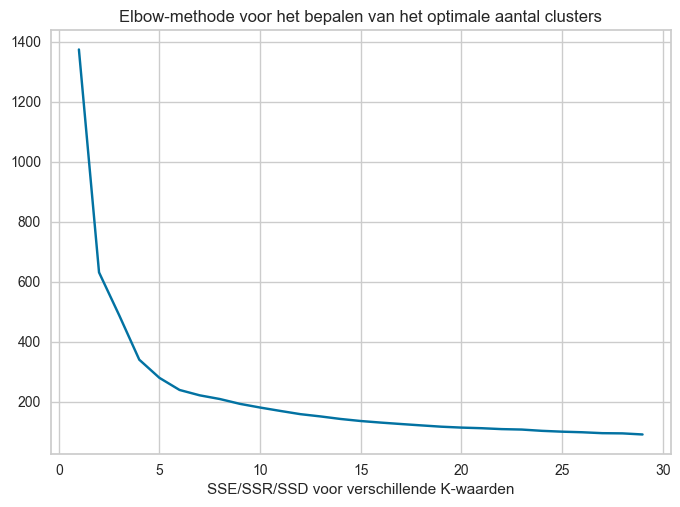

In [20]:
plt.plot(K, ssd, "bx-")
plt.xlabel("SSE/SSR/SSD voor verschillende K-waarden")
plt.title("Elbow-methode voor het bepalen van het optimale aantal clusters")
plt.show()

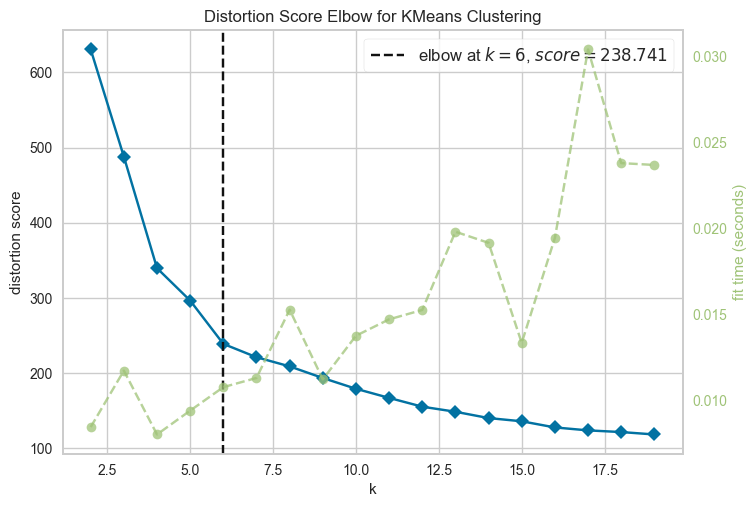

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Vind het optimale aantal clusters met de Elbow-methode
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_scaled)
elbow.show()

In [22]:
print("Optimaal aantal clusters:", elbow.elbow_value_)

Optimaal aantal clusters: 6


### Stap 3: Segmentatie met KMeans

In [23]:
kmeans_final = KMeans(n_clusters=elbow.elbow_value_, random_state=42, n_init=10).fit(df_scaled)
clusters_kmeans = kmeans_final.labels_

In [24]:
# Voeg de segmenten toe aan de originele df_active tabel
df_active['kmeans_cluster_no'] = clusters_kmeans +1 


In [25]:
df_active.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12,tenure_days,recency_days,frequency,monetary,status,kmeans_cluster_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,140.0,799.4,[KADIN],213.0,94.0,5.0,939.4,active,2
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,50.0,160.0,[AKTIFSPOR],667.0,85.0,2.0,210.0,active,2
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,Desktop,Offline,2018-11-18,2021-03-13,2018-11-18,2021-03-13,1.0,2.0,150.9,50.0,[KADIN],925.0,79.0,3.0,200.9,active,2
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,Android App,Android App,2020-03-04,2020-10-18,2020-10-18,2020-03-04,3.0,1.0,60.0,315.9,[AKTIFSPOR],453.0,225.0,4.0,375.9,active,6
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,Mobile,Offline,2020-05-15,2020-08-12,2020-05-15,2020-08-12,1.0,1.0,50.0,113.6,[COCUK],381.0,292.0,2.0,163.6,active,5


### Stap 4: Statistische analyse van elk segment

In [26]:

df_summary = df_active.groupby('kmeans_cluster_no').agg(
    {
        'cust_id': 'nunique',  # benzersiz müşteri sayısı
        **{col: ['count', 'mean', 'median'] for col in num_cols}  
    }
)


In [27]:
df_summary.head(6)

cust_id num_orders_online             num_orders_offline             spend_offline_total              spend_online_total              tenure_days               recency_days              frequency             monetary             
                  nunique             count mean median              count mean median               count  mean median              count  mean median       count   mean median        count  mean median     count mean median    count  mean median
kmeans_cluster_no                                                                                                                                                                                                                                      
1                     809               809  5.4    4.0                809  1.8    1.0                 809 237.8  180.6                809 678.4  440.0         809 1922.7 1870.0          809  76.4   74.0       809  7.2    6.0      809 916.2  687.5
2                    2408              2408  1.8    1.0               2408  1.7    1.0                2408 219.8  160.0               2408 288.2  195.0        2408  652.7  630.5         2408 110.4  109.0      2408  3.5    3.0     2408 508.0  407.9
3                    3656              3656  2.2    2.0               3656  1.7    1.0                3656 226.7  160.0               3656 374.2  257.2        3656  586.3  597.0         3656  30.1   27.0      3656  3.8    3.0     3656 600.9  477.9
4                     543               543  4.5    3.0                543  1.7    1.0                 543 210.6  146.0                543 543.2  321.0         543 1973.3 1901.0          543 275.2  278.0       543  6.2    5.0      543 753.7  555.7
5                    1635              1635  1.9    1.0               1635  1.6    1.0                1635 200.0  140.0               1635 297.8  200.0        1635  707.0  653.0         1635 319.7  323.0      1635  3.6    3.0     1635 497.8  390.9
6                    2194              2194  1.9    1.0               2194  1.6    1.0                2194 203.1  150.0               2194 301.5  208.0        2194  685.3  641.0         2194 202.5  198.0      2194  3.5    3.0     2194 504.6  406.8

### Klantsegmentatie met Hierarchische Clustering

In [28]:
hc_average = linkage(df_scaled, method='average')


#### Bepalen van het aantal clusters


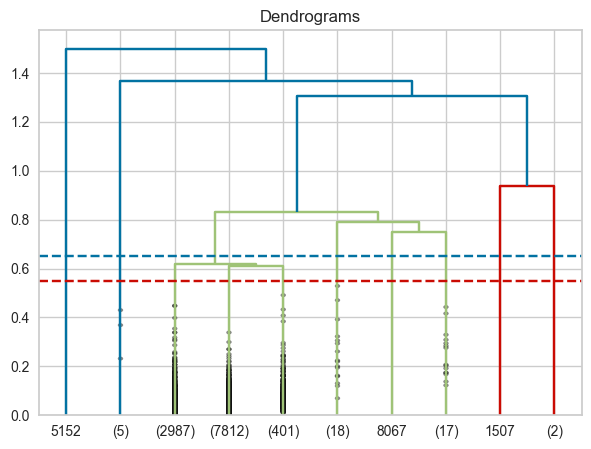

In [29]:

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=0.55, color='r', linestyle='--')
plt.axhline(y=0.65, color='b', linestyle='--')
plt.show()


In [30]:
from scipy.cluster.hierarchy import fcluster
thresholds = [0.55, 0.65]
for t in thresholds:
    clusters = fcluster(hc_average, t, criterion="distance")
    print(f"Aantal clusters voor y = {t}: {len(np.unique(clusters))}")

Aantal clusters voor y = 0.55: 13
Aantal clusters voor y = 0.65: 8


#### Het definitieve model maken

In [31]:
cluster = AgglomerativeClustering(n_clusters=10, linkage="average")

In [32]:

clusters = cluster.fit_predict(df_scaled)

#### Pas toe op de datatabel

In [33]:
df_active["hi_cluster_no"] = clusters
df_active["hi_cluster_no"] = df_active["hi_cluster_no"] + 1
df_active.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12,tenure_days,recency_days,frequency,monetary,status,kmeans_cluster_no,hi_cluster_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,140.0,799.4,[KADIN],213.0,94.0,5.0,939.4,active,2,5
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,50.0,160.0,[AKTIFSPOR],667.0,85.0,2.0,210.0,active,2,5
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,Desktop,Offline,2018-11-18,2021-03-13,2018-11-18,2021-03-13,1.0,2.0,150.9,50.0,[KADIN],925.0,79.0,3.0,200.9,active,2,5
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,Android App,Android App,2020-03-04,2020-10-18,2020-10-18,2020-03-04,3.0,1.0,60.0,315.9,[AKTIFSPOR],453.0,225.0,4.0,375.9,active,6,4
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,Mobile,Offline,2020-05-15,2020-08-12,2020-05-15,2020-08-12,1.0,1.0,50.0,113.6,[COCUK],381.0,292.0,2.0,163.6,active,5,4


In [34]:

hi_summary = df_active.groupby('hi_cluster_no').agg(
    {
        'cust_id': 'nunique', 
        **{col: ['count', 'mean', 'median'] for col in num_cols} 
    }
)

hi_summary = hi_summary.round(1)

hi_summary

cust_id num_orders_online             num_orders_offline             spend_offline_total                 spend_online_total               tenure_days               recency_days              frequency             monetary                
              nunique             count mean median              count mean median               count    mean  median              count   mean median       count   mean median        count  mean median     count mean median    count    mean  median
hi_cluster_no                                                                                                                                                                                                                                             
1                   5                 5 43.4   47.0                  5  1.2    1.0                   5    94.6   109.0                  5 4880.5 4165.0           5 2752.2 2874.0            5 107.6   78.0         5 44.6   48.0        5  4975.1  4295.0
2                   2                 2  2.0    2.0                  2 63.5   63.5                   2  4216.4  4216.4                  2  205.4  205.4           2  835.5  835.5            2  61.0   61.0         2 65.5   65.5        2  4421.8  4421.8
3                  18                18 23.3   21.5                 18  1.6    1.5                  18   207.7   165.0                 18 3224.0 2893.0          18 1647.2 1624.5           18 266.5  264.5        18 24.8   23.0       18  3431.7  3119.1
4                2987              2987  2.3    1.0               2987  1.6    1.0                2987   204.9   140.7               2987  326.5  212.2        2987  944.1  753.0         2987 286.1  293.0      2987  3.9    3.0     2987   531.4   415.6
5                7812              7812  2.0    1.0               7812  1.6    1.0                7812   215.7   160.0               7812  329.2  229.6        7812  669.3  625.0         7812  84.3   72.0      7812  3.7    3.0     7812   544.9   445.0
6                  17                17 18.8   18.0                 17  2.0    1.0                  17   270.7   170.9                 17 3888.8 4129.3          17  949.3  821.0           17  40.5   27.0        17 20.8   23.0       17  4159.5  4273.3
7                 401               401  7.0    5.0                401  1.8    1.0                 401   241.2   172.0                401  864.0  584.4         401 2220.5 2284.0          401  84.7   78.0       401  8.8    7.0      401  1105.2   813.3
8                   1                 1  1.0    1.0                  1  3.0    3.0                   1 18119.1 18119.1                  1 2587.2 2587.2           1   54.0   54.0            1  34.0   34.0         1  4.0    4.0        1 20706.3 20706.3
9                   1                 1 30.0   30.0                  1  2.0    2.0                   1    80.0    80.0                  1 8667.7 8667.7           1  821.0  821.0            1 131.0  131.0         1 32.0   32.0        1  8747.7  8747.7
10                  1                 1  1.0    1.0                  1 87.0   87.0                   1  8432.2  8432.2                  1  140.0  140.0           1  956.0  956.0            1 335.0  335.0         1 88.0   88.0        1  8572.2  8572.2

### linkage-functie en method-parameter = Ward

In [35]:
hc_ward = linkage(df_scaled, method='ward')

Afstand van de laatste fusie: [np.float64(15.683124000936086), np.float64(37.431823557543936), np.float64(37.431823557543936), np.float64(17.396060083023844)]


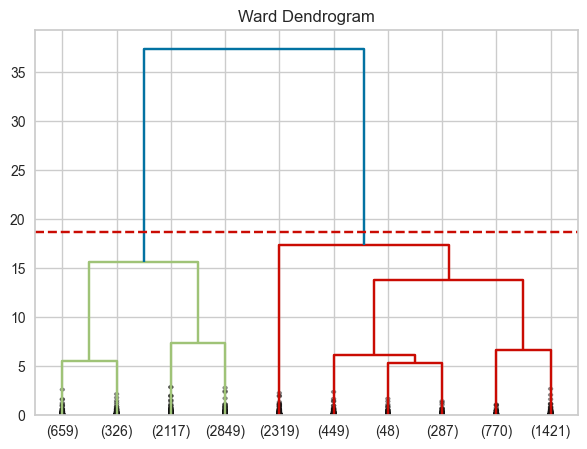

In [36]:

plt.figure(figsize=(7, 5))
plt.title("Ward Dendrogram")

dend = dendrogram(hc_ward, truncate_mode="lastp", p=10, show_contracted=True, leaf_font_size=10)

last_merge = dend['dcoord'][-1]  
print("Afstand van de laatste fusie:", last_merge)

plt.axhline(y=last_merge[1]*0.5, color='r', linestyle='--')  
plt.show()


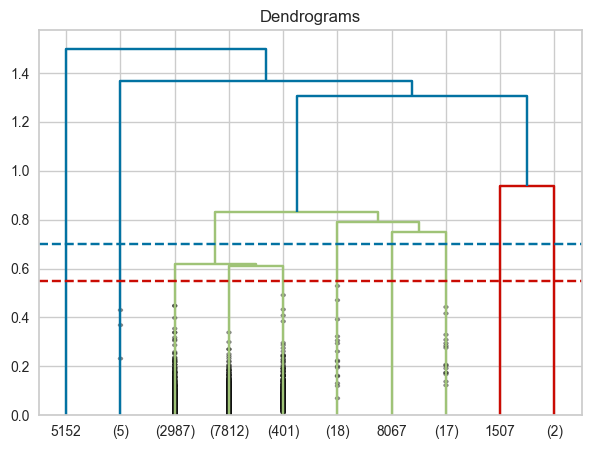

In [37]:
plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=0.55, color='r', linestyle='--')
plt.axhline(y=0.7, color='b', linestyle='--')

plt.show()

### Ward- Final Modeli 

In [38]:
cluster = AgglomerativeClustering(n_clusters=10, linkage="ward")

In [39]:
clusters = cluster.fit_predict(df_scaled)

In [40]:
df_active["hi_clusterward_no"] = clusters
df_active["hi_clusterward_no"] = df_active["hi_clusterward_no"] + 1
df_active.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12,tenure_days,recency_days,frequency,monetary,status,kmeans_cluster_no,hi_cluster_no,hi_clusterward_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,140.0,799.4,[KADIN],213.0,94.0,5.0,939.4,active,2,5,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,50.0,160.0,[AKTIFSPOR],667.0,85.0,2.0,210.0,active,2,5,6
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,Desktop,Offline,2018-11-18,2021-03-13,2018-11-18,2021-03-13,1.0,2.0,150.9,50.0,[KADIN],925.0,79.0,3.0,200.9,active,2,5,6
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,Android App,Android App,2020-03-04,2020-10-18,2020-10-18,2020-03-04,3.0,1.0,60.0,315.9,[AKTIFSPOR],453.0,225.0,4.0,375.9,active,6,4,7
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,Mobile,Offline,2020-05-15,2020-08-12,2020-05-15,2020-08-12,1.0,1.0,50.0,113.6,[COCUK],381.0,292.0,2.0,163.6,active,5,4,8


In [41]:
hi_summary = df_active.groupby('hi_clusterward_no').agg(
    {
        'cust_id': 'nunique',  # benzersiz müşteri sayısı
        **{col: ['count', 'mean', 'median'] for col in num_cols}  # sayısal kolonlar için count, mean, median
    }
)

# Ondalık değerleri tek basamaklı yapmak
hi_summary = hi_summary.round(1)

hi_summary

cust_id num_orders_online             num_orders_offline             spend_offline_total              spend_online_total               tenure_days               recency_days              frequency             monetary              
                  nunique             count mean median              count mean median               count  mean median              count   mean median       count   mean median        count  mean median     count mean median    count   mean median
hi_clusterward_no                                                                                                                                                                                                                                        
1                    2849              2849  2.1    1.0               2849  1.6    1.0                2849 213.7  155.0               2849  355.8  254.9        2849  549.6  580.0         2849  25.5   23.0      2849  3.6    3.0     2849  569.5  473.4
2                     326               326  7.0    5.0                326  1.9    1.0                 326 252.9  184.0                326  844.4  587.9         326 2219.4 2298.0          326  68.3   65.0       326  8.9    7.0      326 1097.3  833.0
3                    2319              2319  1.8    1.0               2319  1.6    1.0                2319 209.6  150.0               2319  297.7  203.0        2319  630.6  624.0         2319 169.2  172.0      2319  3.4    3.0     2319  507.3  405.7
4                     449               449  3.3    3.0                449  1.7    1.0                 449 214.5  150.0                449  372.2  270.0         449 1890.8 1807.0          449 294.2  298.0       449  5.0    4.0      449  586.7  479.8
5                     287               287  4.0    3.0                287  1.6    1.0                 287 201.2  150.0                287  487.8  390.0         287 1684.7 1527.0          287 186.7  187.0       287  5.5    5.0      287  689.0  570.0
6                    2117              2117  2.1    1.0               2117  1.9    1.0                2117 246.5  170.7               2117  339.2  210.0        2117  630.0  623.0         2117  79.0   79.0      2117  3.9    3.0     2117  585.6  430.0
7                     770               770  1.8    1.0                770  1.6    1.0                 770 186.4  131.6                770  255.5  190.0         770  678.2  650.0          770 249.6  247.0       770  3.4    3.0      770  442.0  363.2
8                    1421              1421  1.9    1.0               1421  1.6    1.0                1421 198.4  141.0               1421  311.0  202.0        1421  693.4  643.0         1421 326.0  329.0      1421  3.5    3.0     1421  509.4  400.5
9                     659               659  3.0    2.0                659  1.7    1.0                 659 228.6  180.0                659  384.3  304.9         659 1485.6 1462.0          659  75.0   76.0       659  4.7    4.0      659  612.9  556.9
10                     48                48 23.5   21.5                 48  1.5    1.0                  48 175.0  143.0                 48 3288.0 2854.9          48 2025.9 2208.5           48 186.9  199.0        48 25.0   23.0       48 3463.0 3032.4

In [42]:
# Kruistabel (absolute aantallen)
crosstab = pd.crosstab(df_active["hi_clusterward_no"], df_active["kmeans_cluster_no"])

# Normalisatie: zet elke rij van de hiërarchische clusters om naar % waarden
crosstab_normalized = crosstab.div(crosstab.sum(axis=1), axis=0)

# Vind de sterkste overeenkomsten:
best_matches = crosstab_normalized.idxmax(axis=1)
best_ratios = crosstab_normalized.max(axis=1)

match_summary = pd.DataFrame({
    "Hiërarchisch Cluster": best_matches.index,
    "Sterkste Overeenkomstige KMeans Cluster": best_matches.values,
    "Percentage": (best_ratios * 100).round(2).astype(str) + "%"
})

print("\nSterkste KMeans-overeenkomst voor elk hiërarchisch cluster:")
print(match_summary)



Sterkste KMeans-overeenkomst voor elk hiërarchisch cluster:
                   Hiërarchisch Cluster  Sterkste Overeenkomstige KMeans Cluster Percentage
hi_clusterward_no                                                                          
1                                     1                                        3     96.67%
2                                     2                                        1     97.24%
3                                     3                                        6     63.65%
4                                     4                                        4      88.2%
5                                     5                                        4     39.37%
6                                     6                                        2     61.36%
7                                     7                                        6      73.9%
8                                     8                                        5     99.44%
9                  